## Imports

In [204]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# 用 pipeline 串接 StandardScaler, PCA, LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.model_selection import cross_val_score

# Plot learning curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Validations
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

# 調整svm的kernel 參數 以及C 參數
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## File setup

In [212]:
file = '5_joined_table.csv'
folder_path = 'D:\Courses\資策會_大數據班_BB105\專題\IOT\IOT-Data\\'

df = pd.read_csv(folder_path + file, engine='python')
print('untired count: ' + str(len(df[df['label'] == 0])))
print('tired count: ' + str(len(df[df['label'] == 1])))

exclude_1 = '^(?!BPM)'
include_acc = '^\w{1}_acc'
include_comp = '^\w{1}_comp'
include_2 = '^(Z_acc|BPM)'
include_3 = '^Z_comp|X_comp'
include_4 = '^BPM|Y_comp|X_comp'
include_5 = '^BPM|Z_comp|X_comp|Y_comp'
include_6 = '^X_comp'

x = df.iloc[:,1:-1]
x = x.filter(regex=(include_5))
y = df.loc[:, 'label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

# x_combined = np.vstack((x_train, x_test))
# y_combined = np.hstack((y_train, y_test))

print('\nfeature numbers: ' + str(len(x.columns)))
print(x.columns)


untired count: 4604
tired count: 4043

feature numbers: 19
Index(['X_comp(t-5)', 'Y_comp(t-5)', 'Z_comp(t-5)', 'X_comp(t-4)',
       'Y_comp(t-4)', 'Z_comp(t-4)', 'X_comp(t-3)', 'Y_comp(t-3)',
       'Z_comp(t-3)', 'X_comp(t-2)', 'Y_comp(t-2)', 'Z_comp(t-2)',
       'X_comp(t-1)', 'Y_comp(t-1)', 'Z_comp(t-1)', 'X_comp', 'Y_comp',
       'Z_comp', 'BPM'],
      dtype='object')


## Decision Tree

In [208]:
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None, 
                              min_samples_split=0.05,
                              min_samples_leaf=100, 
                              random_state=1)
tree.fit(x_train_std, y_train)

y_pred = tree.predict(x_train_std)
print('Training Accuracy: %.2f' % accuracy_score(y_train, y_pred))

y_pred = tree.predict(x_test_std)
print('Testing Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Training Accuracy: 0.70
Testing Accuracy: 0.65


## RandomForest

Random Forest train accuracy: 0.990416391276
Random Forest test accuracy:  0.808477842004

-------------- Cross Validation --------------

Test Accuracy: 0.808
CV accuracy scores: [ 0.814  0.812  0.775  0.815  0.82   0.782  0.795  0.767  0.805  0.805]
CV accuracy: 0.799 +/- 0.017

-------------- Learning Curve --------------



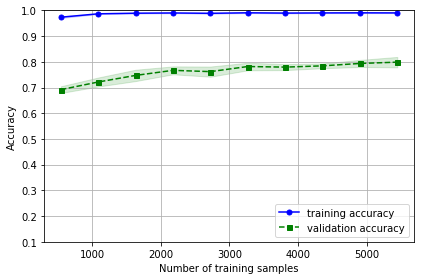

In [209]:
forest = RandomForestClassifier(criterion='entropy', # entropy or gini
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)

forest.fit(x_train_std, y_train)
y_pred = forest.predict(x_test_std)

print('Random Forest train accuracy: ' + str(forest.score(x_train_std, y_train)))
print('Random Forest test accuracy:  ' + str(accuracy_score(y_test, y_pred)))

print('\n-------------- Cross Validation --------------\n')

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(criterion='entropy',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2))])

pipe_rf.fit(x_train_std, y_train)
print('Test Accuracy: %.3f' % pipe_rf.score(x_test_std, y_test))

scores = cross_val_score(estimator=pipe_rf,
                         X=x_train_std,
                         y=y_train,
                         cv=10,
                         n_jobs=2)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

print('\n-------------- Learning Curve --------------\n')

# penalty='l2' : 正規化
train_sizes, train_scores, validation_scores =\
                learning_curve(estimator=pipe_rf,
                               X=x_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 validation_mean + validation_std,
                 validation_mean - validation_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1])
plt.tight_layout()

plt.show()

## Logistic Regression

Logistic Regression train accuracy: 0.539160608063
Logistic Regression test accuracy:  0.534874759152

-------------- Cross Validation --------------

Test Accuracy: 0.540
CV accuracy scores: [ 0.553  0.546  0.549  0.552  0.532  0.545  0.542  0.549  0.55   0.545]
CV accuracy: 0.546 +/- 0.006

-------------- Learning Curve --------------



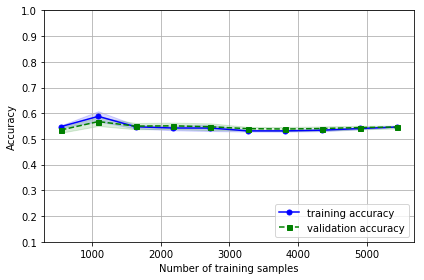


-------------- Validation Curve --------------



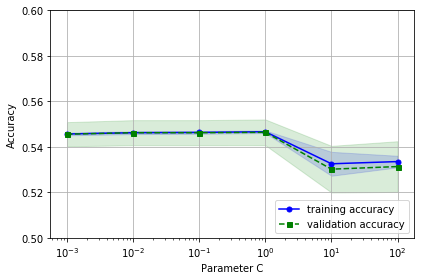

In [213]:
lr = LogisticRegression(C=1000.0, random_state=1)
lr.fit(x_train_std, y_train)
y_pred = lr.predict(x_test_std)

print('Logistic Regression train accuracy: ' + str(lr.score(x_train_std, y_train)))
print('Logistic Regression test accuracy:  ' + str(accuracy_score(y_test, y_pred)))

print('\n-------------- Cross Validation --------------\n')

pipe_lr = Pipeline([('scl', StandardScaler()),
#                     ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(x_train_std, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(x_test_std, y_test))
scores = cross_val_score(estimator=pipe_lr,
                         X=x_train_std,
                         y=y_train,
                         cv=10,
                         n_jobs=2)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

print('\n-------------- Learning Curve --------------\n')

# penalty='l2' : 正規化
train_sizes, train_scores, validation_scores =\
                learning_curve(estimator=pipe_lr,
                               X=x_train_std,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)
# train_sizes=np.linspace(0.1, 1.0, 10) 
# array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, validation_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 validation_mean + validation_std,
                 validation_mean - validation_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.1, 1])
plt.tight_layout()

plt.show()

print('\n-------------- Validation Curve --------------\n')

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, validation_scores = validation_curve(
                estimator=pipe_lr, 
                X=x_train_std, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, validation_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 validation_mean + validation_std,
                 validation_mean - validation_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 0.6])
plt.tight_layout()
plt.show()

### Grid Search using SVM

In [166]:
pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])
# 參數的範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# 一次調好幾個參數   字典類型的list 傳入
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.613069647463
{'clf__C': 1.0, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'}


### Pick best hyperparameters to train

In [172]:
%timeit clf = gs.best_estimator_
%timeit clf.fit(x_train, y_train)
print('Test accuracy: %.3f' % clf.score(x_test, y_test))

55.3 ns ± 0.696 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
3.91 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Test accuracy: 0.602


### Confusion Matrix

In [205]:
y_pred = pipe_lr.predict(x_test)

precision_recall_fscore_support(y_test, y_pred)

(array([ 0.538,  0.692]),
 array([ 0.98 ,  0.052]),
 array([ 0.694,  0.096]),
 array([1374, 1221], dtype=int64))

## SVM

In [102]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.5, C=1.0)
# svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(x_train_std, y_train)
y_pred = svm.predict(x_test_std)
print('資料什麼都沒清理 SVM Accuracy: %.2f' % accuracy_score(y_test, y_pred))

資料什麼都沒清理 SVM Accuracy: 0.60
